# ECEN743 Spring 2024 - Assignment 1
## Tabular RL Algorithms

In this assignment, you will solve the FrozenLake-v0 environment from [Gymnasium](https://gymnasium.farama.org/). You will be using this helper file to answer questions in your assignment. 

**Note that you do not need to start from the scratch. Only write your code between the following lines. Do not modify other parts.**  
"### YOUR CODE HERE"  
"### END OF YOUR CODE"

## Introduction of the FrozenLake Environment

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake. The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment. Holes in the ice are distributed in set locations using a pre-determined map, and the player makes moves until they reach the goal or fall in a hole. The map is given below for your reference

        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
    
### Action Space
The player/agent can take 4 discrete actions, in the range {0,3}
* 0: Move left
* 1: Move down
* 2: Move right 
* 3: Move up


### State Space
The environment consists of 16 states. The state is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).
For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.


### Starting State
The episode starts with the player in state [0] (location [0, 0]).


### Rewards 

* Reach goal: +1
* Reach hole: 0
* Reach frozen: 0

### Episode End
The episode ends if the following happens:
#### 1.Termination:
* The player moves into a hole.
* The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).

#### 2.Truncation:
* The length of the episode is 100 for 4x4 environment.

For more info refer to source: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

### The Environment Parameters
* Use discount factor, $\gamma = 0.9$
* The environment is slippery, ie., the transition kernel is stochastic.
* The transition kernel P is a dictionary. 
* P[state][action] is tuples with (probability, nextstate, reward, terminal)

**Run the following initializer. Make sure you can execute it without any error.**

If you wish to finish this assignment using Google Colab. Uncomment the following commands and run them.

In [1]:
# !pip install swig
# !pip install gymnasium[box2d]

In [2]:
import gymnasium as gym
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
np.set_printoptions(precision=4, suppress=True)

env = gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=True)

gamma = 0.9


def fancy_visual(value_func,policy_int):    
    grid = 4    
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap="icefire",vmax=1.1, robust = True,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()

## 1. Q-value iteration

### Explanation of the parameters
* `Q_prev` is the Q-value function from the previous iteration.
* `Q_curr` is the Q-value function of current iteration. In each iteration, you need to use model, reward, and the Q-value function from previous iteration (`Q_prev`) to compute `Q_curr`.
* You can use
    * `n = np.array([n for (p,n,r,t) in env.P[s][a]])` to access the information of the possible next states if you pick action `a` in state `s`. **Note that for conciseness, `env.P[s][a]` omits entries that are not reachable from `(s,a)`;** 
    * `p = np.array([p for (p,n,r,t) in env.P[s][a]])` to access the transition probabilities at any state-action pair `(s,a)`. For example, in state `4`, if you choose to move right (`a=2`), then `env.P[4][2]` outputs:
        ```
        [(0.3333333333333333, 8, 0.0, False),
         (0.3333333333333333, 5, 0.0, True),
         (0.3333333333333333, 0, 0.0, False)]
        ```
        That is, there is a one third chance that we end up in either state `8`, `5`, or `0`. **This is very import since the indexing of this array is totally irrelavant to the indexing of your Q-value function array.** In this particular example, you need to update `Q_curr[4]` using `p[0]` and `Q_prev[8]`, `p[1]` and `Q_prev[5]`, `p[2]` and `Q_prev[0]` (Why?); 
    * `r = np.array([r for (p,n,r,t) in env.P[s][a]])` to access the reward.

### Your Task
1. Complete the Bellman update in Task 1 below. In particular, calculate the current Q-value function `Q_curr` using the previous Q-value function `Q_prev`.
2. Compute the optimal value function `Vopt` and the optimal policy `Policyopt`.

In [3]:
no_of_actions = env.action_space.n
no_of_states = env.observation_space.n

epsilon = 1e-5

Q_prev = np.array([[0.0]*no_of_actions for i in range(no_of_states)])
Q_delta = []
delta = 1

while (delta > epsilon):
    Q_curr = np.array([[0.0]*no_of_actions for i in range(no_of_states)])
    # Task 1
    ### YOUR CODE HERE
    # Q_curr = []
    for state in range(16): #max episode length
        for action in range(4):
            probs = [
                    p * (r + gamma * np.max(Q_prev[s])) for (p,s,r,t) in env.P[state][action]
                ]
            Q_curr[state, action] = sum(probs)

    
    ### END OF YOUR CODE
    delta = np.linalg.norm(Q_curr.flatten() - Q_prev.flatten())
    Q_delta.append(delta)
    Q_prev = Q_curr

# Task 2
### YOUR CODE HERE
Vopt = [max(state) for state in Q_curr]
Policyopt = [np.argmax(state) for state in Q_curr]
### END OF YOUR CODE


/home/cake/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


### 1a. Optimal Policy and Value function

You do not need to modify the code below but you have to run it before submission.

In [4]:
env.close()
print("Optimal Value function: ")
print(Vopt)
print("Optimal Policy")
print(Policyopt)

Optimal Value function: 
[0.06887237368658759, 0.06139886793838437, 0.07439831027923255, 0.05579472766299776, 0.09183768940278578, 0.0, 0.11220204522635435, 0.0, 0.14542271340650473, 0.2474877596435023, 0.29961111968644805, 0.0, 0.0, 0.3799292647532213, 0.6390166722547349, 0.0]
Optimal Policy
[0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


### 1b. Plot $||Q_k - Q_{k-1}||$

You do not need to modify the code below but you have to run it before submission.

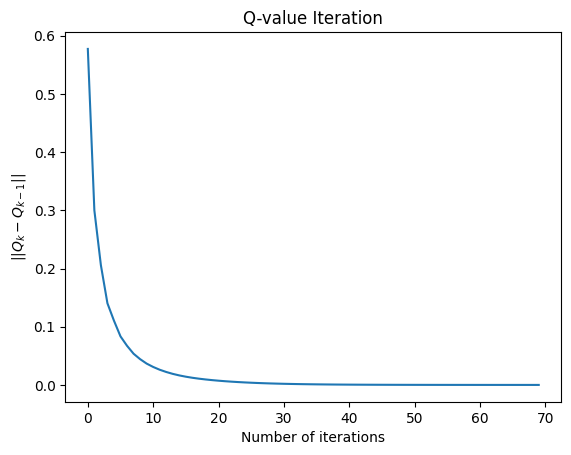

In [5]:
plt.plot(range(len(Q_delta)),Q_delta)
plt.title("Q-value Iteration")
plt.xlabel("Number of iterations")
plt.ylabel("$||Q_k - Q_{k-1}||$")
plt.show()  

### 1c. Heat map

You do not need to modify the code below but you have to run it before submission.

Value Function [0.06887237368658759, 0.06139886793838437, 0.07439831027923255, 0.05579472766299776, 0.09183768940278578, 0.0, 0.11220204522635435, 0.0, 0.14542271340650473, 0.2474877596435023, 0.29961111968644805, 0.0, 0.0, 0.3799292647532213, 0.6390166722547349, 0.0]
Policy [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


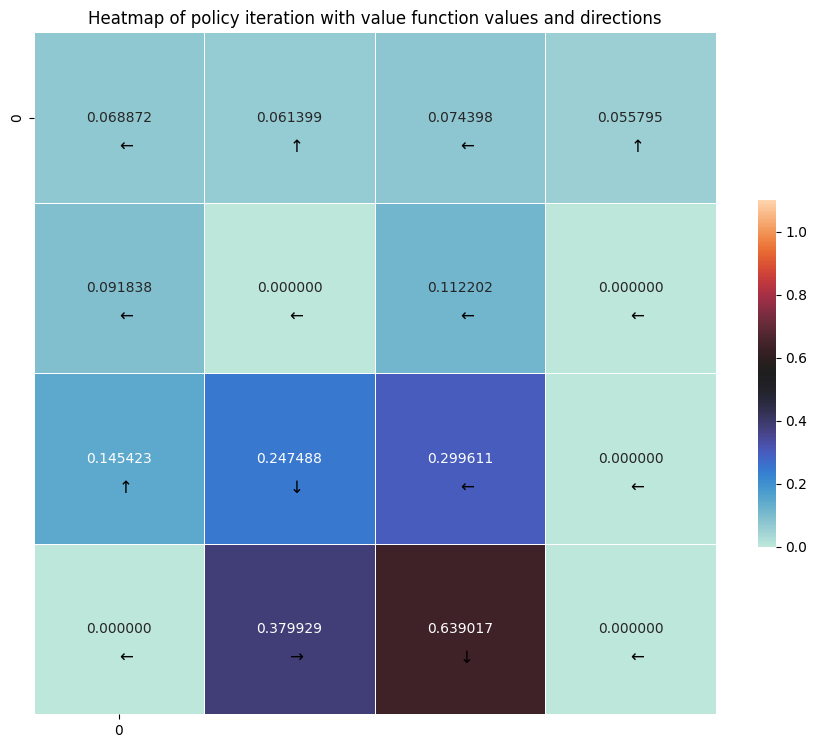

In [6]:
fancy_visual(Vopt,Policyopt)

## 2. Policy Evaluation  

### 2a. linear system of equations

### Hint: one way to do this
1. Compute `P_opt` which is a $|\mathcal{S}|\times|\mathcal{S}|$ matrix where the entry in the $i$-th row, $j$-th column represents the probability of going from state `i` to state `j` by executing the optimal policy obtained by QVI in Problem 1.

2. Compute `r_opt` which is a $|\mathcal{S}|$-dimensional vector whose $i$-th element is $$\mathbb{E}_{a\sim \pi^*(\cdot\mid s)}\mathbb{E}_{s'\sim P(\cdot\mid s,a)}[r(s,a,s')] \stackrel{(a)}{=} \mathbb{E}_{s'\sim P(\cdot\mid s,\pi^*(s))}[r(s,\pi^*(s),s')]$$, where $(a)$ is because $\pi^*$ is deterministic.

3. Recall the Bellman consistency equation, for any policy $\pi$, we have $V^{\pi} = (I-\gamma P^{\pi})^{-1} r^{\pi}$. Rearrange the terms, we can look at the system of linear equations, $(I-\gamma P^{\pi}) V^{\pi} = r^{\pi}$, and solve for $V^\pi$.

4. For $\pi_{\mathrm{unif}}$, repeat the steps above but be careful since the policy is no longer deterministic. You need to do extra work in step 2.


In [7]:
# Optimal policy
I = np.identity(no_of_states)
P_opt = np.zeros((no_of_states,no_of_states))
r_opt = np.zeros(no_of_states)

### YOUR CODE HERE
for idx, action in enumerate(Policyopt):
    x, y = idx % 4, idx // 4
    if idx in [5,7,11,12,15]:
        P_opt[idx,idx] = 1
        continue
    dirs = [(1,0), (0,-1), (-1,0), (0,1)]
    del dirs[action]
    for xd, yd in dirs:
        nx, ny = np.clip(x + xd,0,3), np.clip(y + yd,0,3)
        P_opt[idx, ny * 4 + nx] += 1/3
    
r_opt = [sum([p * r for (p, s,r,t) in env.P[state][Policyopt[state]] ]) for state in range(16)]

### END OF YOUR CODE

# Uniform policy
I = np.identity(no_of_states)
P_unif = np.zeros((no_of_states,no_of_states))
r_unif = np.zeros(no_of_states)

### YOUR CODE HERE
for idx in range(16):
    x, y = idx % 4, idx // 4
    if idx in [5,7,11,12,15]:
        P_opt[idx,idx] = 1
        continue
    for action in range(4):
        dirs = [(1,0), (0,-1), (-1,0), (0,1)]
        del dirs[action]
        for xd, yd in dirs:
            nx, ny = np.clip(x + xd,0,3), np.clip(y + yd,0,3)
            P_unif[idx, ny * 4 + nx] += 1/12

r_unif[14] = 1/4
### END OF YOUR CODE

print("Value function under optimal policy: ")
### YOUR CODE HERE
print(np.linalg.inv(I - gamma * P_opt) @ r_opt)
# print your value function for the optimal policy
### END OF YOUR CODE

print("Value function under uniformly random policy:")
### YOUR CODE HERE
# print your value function for the uniform policy
print(np.linalg.inv(I - gamma * P_unif) @ r_unif)
### END OF YOUR CODE

Value function under optimal policy: 
[0.0689 0.0614 0.0744 0.0558 0.0919 0.     0.1122 0.     0.1454 0.2475
 0.2996 0.     0.     0.3799 0.639  0.    ]
Value function under uniformly random policy:
[0.0045 0.0042 0.0101 0.0041 0.0067 0.     0.0263 0.     0.0187 0.0576
 0.107  0.     0.     0.1304 0.3915 0.    ]


/home/cake/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


### 2b. Iterative Method

Recall the Bellman consistency equation that for any policy $\pi$, we have
$$
V^\pi(s) = \mathbb{E}_{a\sim \pi(\cdot\mid s)}\mathbb{E}_{s'\sim P(\cdot\mid s,a)}[r(s,a,s') + \gamma V^\pi(s')].
$$

Please keep `epsilon` unchanged. Remember to update the `delta` in the while loop to reflect the current convergency of the contraction mapping.

In [8]:
epsilon = 1e-10
#optimal policy
V_prev = np.array([0.0]*no_of_states)
delta = 1
while(delta > epsilon):
    ### YOUR CODE HERE
    V_curr = np.zeros(no_of_states)
    for state in range(16):
        V_curr[state] = max([sum([
            p * (r + gamma * V_prev[s]) for (p,s,r,t) in env.P[state][action]
        ]) for action in range(4)])

    delta = np.linalg.norm(V_curr - V_prev) 
    ### END OF YOUR CODE
    V_prev = V_curr

print("Value function under optimal policy: ")
print(V_prev)
#uniform policy
V_prev = np.array([0.0]*no_of_states)
delta = 1
while(delta > epsilon):
    ### YOUR CODE HERE
    V_curr = np.zeros(no_of_states)
    for state in range(16):
        V_curr[state] = sum([(1/4) *sum([
            p * (r + gamma * V_prev[s]) for (p,s,r,t) in env.P[state][action]
        ]) for action in range(4)])

    delta = np.linalg.norm(V_curr - V_prev) 
    ### END OF YOUR CODE
    V_prev = V_curr
    
print("Value function under uniform policy: ")
print(V_prev)

Value function under optimal policy: 
[0.0689 0.0614 0.0744 0.0558 0.0919 0.     0.1122 0.     0.1454 0.2475
 0.2996 0.     0.     0.3799 0.639  0.    ]
Value function under uniform policy: 
[0.0045 0.0042 0.0101 0.0041 0.0067 0.     0.0263 0.     0.0187 0.0576
 0.107  0.     0.     0.1304 0.3915 0.    ]


### 2c. Comparison

**Write your answer below.**  
Answer:




## 3. Policy Iteration

### Hint: one way to do this
1. In the policy evaluation step, calculate `P_pol` matrix. This should be identical to Problem **2a**.
2. Calculate `r_pol` which is a $|\mathcal{S}|$-dimensional vector. You should have
$r_\mathrm{pol}[s] = \mathbb{E}_{a\sim\pi_{\mathrm{prev}}(\cdot\mid s)} \mathbb{E}_{s'\sim P(\cdot\mid s,a)} [r(s,a,s')]. $
Note that this should be just one line. Refer to **Explanation of the parameters** in **Problem 1** for `p`, `n`, and `r`.  
3. Compute `V_curr` using `P_pol` and `r_pol`. It represents the value function of the current policy $\pi_k$.
4. Compute new policy $\pi_{k+1}$ using the value function of $\pi_k$. In particular, you need to use `V_pol_prev` to compute `pi_curr`.

**Note, for this problem, you can remove everything below and start from the scratch. **

**However, you have to save your optimal policy as `piopt_politer` and your optimal value function as `Vopt_politer`.**

/home/cake/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


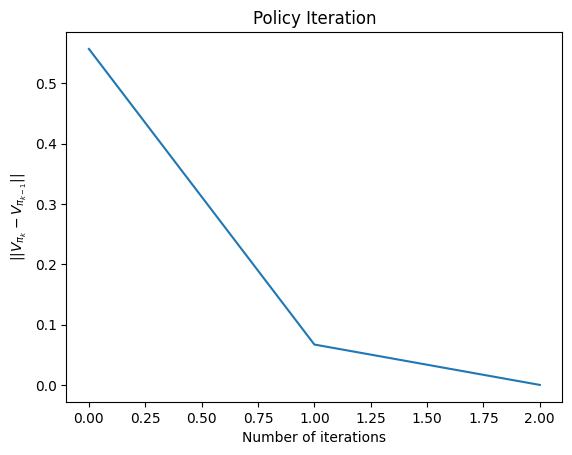

In [36]:
pi_prev = np.random.randint(0,no_of_actions,size=no_of_states)
V_pi_delta = []
V_pol_prev = np.array([0.0]*no_of_states)

epsilon_o = 1e-5
epsilon_i = 1e-10

delta_o = 1
while(delta_o > 0):
    ### YOUR CODE HERE
    # some prep work for policy evaluation
    P_pol = np.zeros((no_of_states, no_of_states))
    for idx, action in enumerate(pi_prev):
        x, y = idx % 4, idx // 4
        if idx in [5,7,11,12,15]:
            P_opt[idx,idx] = 1
            continue
        dirs = [(1,0), (0,-1), (-1,0), (0,1)]
        del dirs[action]
        for xd, yd in dirs:
            nx, ny = np.clip(x + xd,0,3), np.clip(y + yd,0,3)
            P_pol[idx, ny * 4 + nx] += 1/3

    r_pol = [sum([p * r for (p, s,r,t) in env.P[state][pi_prev[state]]]) for state in range(16)]
    V_pol_prev_i = np.linalg.inv(I - gamma * P_pol) @ r_pol
    ###
    delta_i = np.linalg.norm(V_curr - V_pol_prev_i)
    V_pi_delta.append(delta_i)

    V_pol_prev = V_pol_prev_i
    pi_curr = np.zeros((no_of_states,), dtype=int)
    ### YOUR CODE HERE
    # design your own policy improvement steps
    for state in range(16):
        x, y = state % 4, state // 4

        vals = [sum([p * (r + gamma *V_pol_prev[s])
                  for (p,s,r,t) in env.P[state][action]])
                    for action in range(4)]
        
        pi_curr[state] = np.argmax(vals)

    #print(pi_curr)
    ### END OF YOUR CODE
    # delta_o = compare pi_curr and pi_prev
    delta_o = np.linalg.norm(pi_curr - pi_prev)
    pi_prev = pi_curr  # update while loop

Vopt_politer = V_curr
piopt_politer = pi_curr

plt.plot(range(len(V_pi_delta)),V_pi_delta)
plt.title("Policy Iteration")
plt.xlabel("Number of iterations")
plt.ylabel("$||V_{\pi_k} - V_{\pi_{k-1}}||$")
plt.show()

# Remember to save your optimal policy as `piopt_politer` and your optimal value function as `Vopt_politer`.

### 3a. Optimal Policy and Value function

You do not need to modify the code below but you have to run it before submission.

In [37]:
print("Optimal Value function: ")
print(Vopt_politer)
print("Optimal Policy")
print(piopt_politer)

Optimal Value function: 
[0.0689 0.0614 0.0744 0.0558 0.0919 0.     0.1122 0.     0.1454 0.2475
 0.2996 0.     0.     0.3799 0.639  0.    ]
Optimal Policy
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


### 3b. Compare the convergence of QVI and PI

**Write your answer below.**  
Answer: